# Autoencoders
Сунгатуллин Руслан

__Описание задачи:__
Реализация автоэнкодера для сжатия лиц людей, дорисовка улыбок грустным людям на фото =) + некоторые другие интересные применения автоэнкодеров

__Описание работы:__
Основная часть: Разобраться с тем, что такое автоэнкодер, как он устроен, зачем применяется. Реализовать свой автоэнкодер с нуля, обучить на датасете лиц людей. Нацчиться с помощью автоэнкодеров делать из грустных людей на фото веселых =)
Допчасти: Поиграться с тем, что можно делать, используя автоэнкодеры / разобраться, что такое вариационный автоэнкодер и реализовать его. 

__Основные этапы:__ 
1. Чтение литературы по автоэнкодерам
2. Реализация обычного автоэекодера, обучение на датасете лиц людей.
3. Научиться дорисовывать улыбки грустным людям на фото с помощью автоэнкодеров 
4. (доп) реализация вариационного автоэнкодера
5. (доп) исследование других применений автоэнкодеров (кроме дорисовки улыбок/носов/ушей/очков)

__Критерии оценивания:__ 
Основная часть -- 6 баллов.
Каждая допчасть (вариационный автоэнкодер и допприменения) по два балла плюс.

__Литература__:
https://habr.com/ru/post/331382/
https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

## Loading libs

In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import time
from sklearn.model_selection import train_test_split
import glob
import torch.nn.functional as F
from imageio import imread
from PIL import Image
import os
import random
from IPython.display import clear_output
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision

## Configuration

In [0]:
device = torch.device('cuda:0')
batch_size = 64

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Loading dataset

In [89]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs
    
data, attrs = fetch_dataset()
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
print(IMAGE_H, IMAGE_W)

45 45


In [0]:
DATASET_PATH ="./lfw-deepfunneled/"
ATTRIBUTES_PATH = "./lfw_attributes.txt"

In [91]:
dataset = []
for path in glob.iglob(os.path.join(DATASET_PATH, "**", "*.jpg")):
    person = path.split("/")[-2]
    dataset.append({"person":person, "path": path})
    
dataset = pd.DataFrame(dataset)
#too much Bush
dataset = dataset.groupby("person").filter(lambda x: len(x) < 25 )
dataset.head(10)

,person,path
0,Thabo_Mbeki,./lfw-deepfunneled/Thabo_Mbeki/Thabo_Mbeki_000...
1,Thabo_Mbeki,./lfw-deepfunneled/Thabo_Mbeki/Thabo_Mbeki_000...
2,Thabo_Mbeki,./lfw-deepfunneled/Thabo_Mbeki/Thabo_Mbeki_000...
3,Thabo_Mbeki,./lfw-deepfunneled/Thabo_Mbeki/Thabo_Mbeki_000...
4,Thabo_Mbeki,./lfw-deepfunneled/Thabo_Mbeki/Thabo_Mbeki_000...
5,Kalpana_Chawla,./lfw-deepfunneled/Kalpana_Chawla/Kalpana_Chaw...
6,Kalpana_Chawla,./lfw-deepfunneled/Kalpana_Chawla/Kalpana_Chaw...
7,Kalpana_Chawla,./lfw-deepfunneled/Kalpana_Chawla/Kalpana_Chaw...
8,Kalpana_Chawla,./lfw-deepfunneled/Kalpana_Chawla/Kalpana_Chaw...
9,Kalpana_Chawla,./lfw-deepfunneled/Kalpana_Chawla/Kalpana_Chaw...


In [0]:
N_CHANNELS = 3

In [0]:
data = np.array(data / 255., dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.3, random_state=SEED)

In [0]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

# Autoencoder

### Model

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1, end_dim=-1)

In [0]:
class Encoder(nn.Module):
  def __init__(self, latent_size):
    super(Encoder, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=0, stride=1),
        nn.LeakyReLU(0.05, True),
        nn.BatchNorm2d(8),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=0, stride=1),
        nn.LeakyReLU(0.05, True),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=1),
        nn.LeakyReLU(0.3, True),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(288, latent_size)
    )
    
  def forward(self, x):
    return self.model(x)

In [0]:
class Decoder(nn.Module):
  def __init__(self, latent_size):
    super(Decoder, self).__init__()
    self.fc = nn.Linear(latent_size, 289)
    self.model = nn.Sequential(
        nn.ConvTranspose2d(in_channels=1, out_channels=8, kernel_size=5),
        nn.LeakyReLU(0.05, True),
        nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=5),
        nn.LeakyReLU(0.05, True),
        nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=5),
        nn.LeakyReLU(0.05, True),
        nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5),
        nn.LeakyReLU(0.05, True),
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5),
        nn.LeakyReLU(0.05, True),
        nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5),
        nn.LeakyReLU(0.05, True),
        nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=5),
        nn.LeakyReLU(0.05, True)
    )
  
  def forward(self, x):
    x = self.fc(x)
    x = x.view(x.size(0), 1, 17, 17)
    return self.model(x)

In [0]:
class Autoencoder(nn.Module):
  def __init__(self, latent_size):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(latent_size)
    self.decoder = Decoder(latent_size)

  def forward(self, x):
    x = x.permute(0,3,1,2)
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

### Train

In [0]:
model = Autoencoder(1024).to(device)

In [0]:
def get_batch(data, batch_size=64):
    total_len = data.shape[0]
    for i in range(0, total_len, batch_size):
        yield data[i:min(i+batch_size,total_len)]

def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass
        
def fit_epoch(model, train_x, criterion, optimizer, batch_size):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        
        encoder, decoder = model(inputs)
        
        outputs = decoder.permute(0,2,3,1)
        
        loss = criterion(outputs,inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch(model, x_val, criterion):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val):
        inputs = inputs.to(device)
        
        with torch.set_grad_enabled(False):
            encoder, decoder = model(inputs)
            
            outputs = decoder.permute(0,2,3,1)
                
            loss = criterion(outputs,inputs)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]
        
        pic_input = torch.FloatTensor(pic.unsqueeze(0))
            
        pic_input = pic_input.to(device)        
        encoder, decoder = model(pic_input)
        
        pic_output = decoder.permute(0,2,3,1)
            
        pic_output = pic_output.to("cpu")        
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train(train_x, val_x, model, epochs=10, batch_size=32):     
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch(model,train_x,criterion,optimizer,batch_size)
            val_loss = eval_epoch(model,val_x,criterion)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

epoch:   2%|▏         | 1/50 [00:03<03:09,  3.88s/it]

loss:  0.04347504190452721

Epoch 001 train_loss: 0.0435 val_loss: 0.0219


epoch:   4%|▍         | 2/50 [00:07<02:59,  3.74s/it]

loss:  0.016745844230703685

Epoch 002 train_loss: 0.0167 val_loss: 0.0144


epoch:   6%|▌         | 3/50 [00:10<02:51,  3.66s/it]

loss:  0.01376828836520081

Epoch 003 train_loss: 0.0138 val_loss: 0.0130


epoch:   8%|▊         | 4/50 [00:14<02:45,  3.59s/it]

loss:  0.01265712502695944

Epoch 004 train_loss: 0.0127 val_loss: 0.0133


epoch:  10%|█         | 5/50 [00:17<02:39,  3.54s/it]

loss:  0.011858869957859102

Epoch 005 train_loss: 0.0119 val_loss: 0.0119


epoch:  12%|█▏        | 6/50 [00:21<02:34,  3.52s/it]

loss:  0.011187108709760335

Epoch 006 train_loss: 0.0112 val_loss: 0.0113


epoch:  14%|█▍        | 7/50 [00:24<02:30,  3.51s/it]

loss:  0.010690266613079154

Epoch 007 train_loss: 0.0107 val_loss: 0.0105


epoch:  16%|█▌        | 8/50 [00:28<02:27,  3.50s/it]

loss:  0.010231609650604103

Epoch 008 train_loss: 0.0102 val_loss: 0.0102


epoch:  18%|█▊        | 9/50 [00:31<02:23,  3.50s/it]

loss:  0.009921236682845199

Epoch 009 train_loss: 0.0099 val_loss: 0.0100


epoch:  20%|██        | 10/50 [00:35<02:20,  3.51s/it]

loss:  0.00967380955491377

Epoch 010 train_loss: 0.0097 val_loss: 0.0098


epoch:  22%|██▏       | 11/50 [00:38<02:17,  3.53s/it]

loss:  0.009497413544551185

Epoch 011 train_loss: 0.0095 val_loss: 0.0097


epoch:  24%|██▍       | 12/50 [00:42<02:14,  3.54s/it]

loss:  0.009272725429871807

Epoch 012 train_loss: 0.0093 val_loss: 0.0094


epoch:  26%|██▌       | 13/50 [00:45<02:11,  3.56s/it]

loss:  0.009081153168302516

Epoch 013 train_loss: 0.0091 val_loss: 0.0092


epoch:  28%|██▊       | 14/50 [00:49<02:09,  3.60s/it]

loss:  0.008971400171842264

Epoch 014 train_loss: 0.0090 val_loss: 0.0091


epoch:  30%|███       | 15/50 [00:53<02:05,  3.60s/it]

loss:  0.008822362580053185

Epoch 015 train_loss: 0.0088 val_loss: 0.0090


epoch:  32%|███▏      | 16/50 [00:56<02:02,  3.60s/it]

loss:  0.008743441137282745

Epoch 016 train_loss: 0.0087 val_loss: 0.0089


epoch:  34%|███▍      | 17/50 [01:00<01:58,  3.59s/it]

loss:  0.008622435091630272

Epoch 017 train_loss: 0.0086 val_loss: 0.0088


epoch:  36%|███▌      | 18/50 [01:03<01:54,  3.58s/it]

loss:  0.008541047403021999

Epoch 018 train_loss: 0.0085 val_loss: 0.0088


epoch:  38%|███▊      | 19/50 [01:07<01:50,  3.57s/it]

loss:  0.008479241249353989

Epoch 019 train_loss: 0.0085 val_loss: 0.0087


epoch:  40%|████      | 20/50 [01:10<01:46,  3.55s/it]

loss:  0.008425012070523655

Epoch 020 train_loss: 0.0084 val_loss: 0.0086


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
epoch:  42%|████▏     | 21/50 [01:14<01:42,  3.54s/it]

loss:  0.008307218556494817

Epoch 021 train_loss: 0.0083 val_loss: 0.0086


epoch:  44%|████▍     | 22/50 [01:17<01:38,  3.53s/it]

loss:  0.008214904248066571

Epoch 022 train_loss: 0.0082 val_loss: 0.0085


epoch:  46%|████▌     | 23/50 [01:21<01:35,  3.52s/it]

loss:  0.008114258217746797

Epoch 023 train_loss: 0.0081 val_loss: 0.0084


epoch:  48%|████▊     | 24/50 [01:24<01:31,  3.51s/it]

loss:  0.008063475730950417

Epoch 024 train_loss: 0.0081 val_loss: 0.0084


epoch:  50%|█████     | 25/50 [01:28<01:27,  3.51s/it]

loss:  0.008022083003559837

Epoch 025 train_loss: 0.0080 val_loss: 0.0083


epoch:  52%|█████▏    | 26/50 [01:31<01:24,  3.51s/it]

loss:  0.007991247248390447

Epoch 026 train_loss: 0.0080 val_loss: 0.0084


epoch:  54%|█████▍    | 27/50 [01:35<01:20,  3.51s/it]

loss:  0.007972874513462834

Epoch 027 train_loss: 0.0080 val_loss: 0.0083


epoch:  56%|█████▌    | 28/50 [01:38<01:17,  3.50s/it]

loss:  0.00786301846737447

Epoch 028 train_loss: 0.0079 val_loss: 0.0083


epoch:  58%|█████▊    | 29/50 [01:42<01:13,  3.50s/it]

loss:  0.007801679340393647

Epoch 029 train_loss: 0.0078 val_loss: 0.0083


epoch:  60%|██████    | 30/50 [01:45<01:10,  3.51s/it]

loss:  0.007737967112789983

Epoch 030 train_loss: 0.0077 val_loss: 0.0083


epoch:  62%|██████▏   | 31/50 [01:49<01:06,  3.50s/it]

loss:  0.007709563821554184

Epoch 031 train_loss: 0.0077 val_loss: 0.0083


epoch:  64%|██████▍   | 32/50 [01:52<01:03,  3.50s/it]

loss:  0.007779050250740155

Epoch 032 train_loss: 0.0078 val_loss: 0.0083


epoch:  66%|██████▌   | 33/50 [01:56<00:59,  3.51s/it]

loss:  0.00773668676128854

Epoch 033 train_loss: 0.0077 val_loss: 0.0083


epoch:  68%|██████▊   | 34/50 [01:59<00:56,  3.50s/it]

loss:  0.007675176316305347

Epoch 034 train_loss: 0.0077 val_loss: 0.0082


epoch:  70%|███████   | 35/50 [02:03<00:52,  3.51s/it]

loss:  0.007616864721412244

Epoch 035 train_loss: 0.0076 val_loss: 0.0082


epoch:  72%|███████▏  | 36/50 [02:07<00:49,  3.52s/it]

loss:  0.007570679058199343

Epoch 036 train_loss: 0.0076 val_loss: 0.0082


epoch:  74%|███████▍  | 37/50 [02:10<00:45,  3.51s/it]

loss:  0.0075378043026379914

Epoch 037 train_loss: 0.0075 val_loss: 0.0081


epoch:  76%|███████▌  | 38/50 [02:14<00:42,  3.52s/it]

loss:  0.007503939619206864

Epoch 038 train_loss: 0.0075 val_loss: 0.0081


epoch:  78%|███████▊  | 39/50 [02:17<00:38,  3.52s/it]

loss:  0.007475680116078128

Epoch 039 train_loss: 0.0075 val_loss: 0.0080


epoch:  80%|████████  | 40/50 [02:21<00:35,  3.55s/it]

loss:  0.007449139366331308

Epoch 040 train_loss: 0.0074 val_loss: 0.0081


epoch:  82%|████████▏ | 41/50 [02:24<00:31,  3.54s/it]

loss:  0.007487474597342636

Epoch 041 train_loss: 0.0075 val_loss: 0.0080


epoch:  84%|████████▍ | 42/50 [02:28<00:28,  3.54s/it]

loss:  0.007451042957279993

Epoch 042 train_loss: 0.0075 val_loss: 0.0080


epoch:  86%|████████▌ | 43/50 [02:31<00:24,  3.53s/it]

loss:  0.007374038574812205

Epoch 043 train_loss: 0.0074 val_loss: 0.0080


epoch:  88%|████████▊ | 44/50 [02:35<00:21,  3.54s/it]

loss:  0.007311736866021934

Epoch 044 train_loss: 0.0073 val_loss: 0.0080


epoch:  90%|█████████ | 45/50 [02:38<00:17,  3.53s/it]

loss:  0.007249816357279601

Epoch 045 train_loss: 0.0072 val_loss: 0.0080


epoch:  92%|█████████▏| 46/50 [02:42<00:14,  3.52s/it]

loss:  0.0072289508710736815

Epoch 046 train_loss: 0.0072 val_loss: 0.0081


epoch:  94%|█████████▍| 47/50 [02:45<00:10,  3.52s/it]

loss:  0.007240045320080674

Epoch 047 train_loss: 0.0072 val_loss: 0.0079


epoch:  96%|█████████▌| 48/50 [02:49<00:07,  3.51s/it]

loss:  0.007270072562539059

Epoch 048 train_loss: 0.0073 val_loss: 0.0080


epoch:  98%|█████████▊| 49/50 [02:52<00:03,  3.52s/it]

loss:  0.007253174794756848

Epoch 049 train_loss: 0.0073 val_loss: 0.0079


epoch: 100%|██████████| 50/50 [02:56<00:00,  3.52s/it]

loss:  0.007245114557445049

Epoch 050 train_loss: 0.0072 val_loss: 0.0080


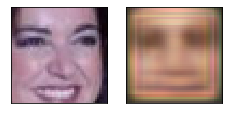

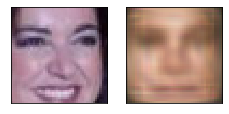

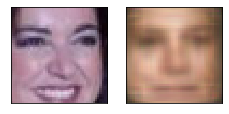

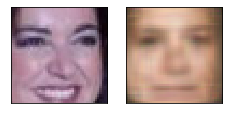

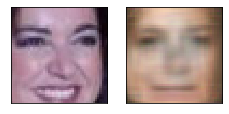

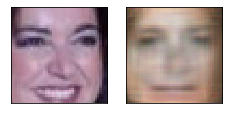

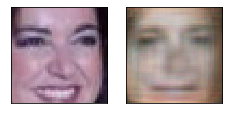

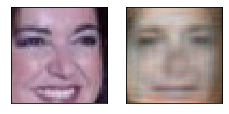

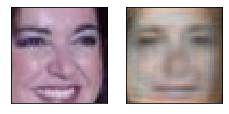

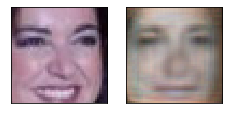

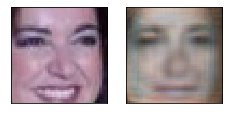

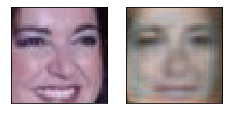

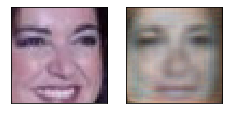

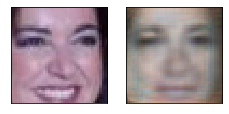

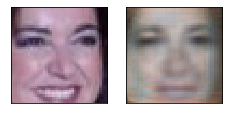

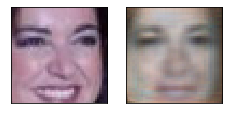

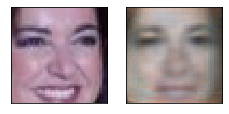

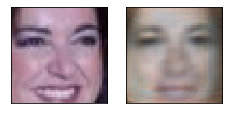

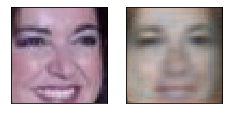

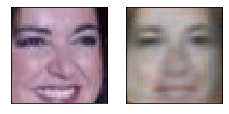

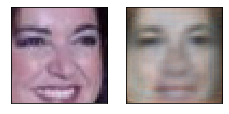

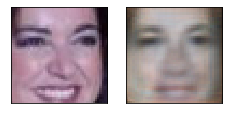

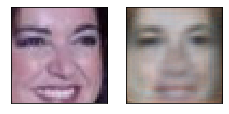

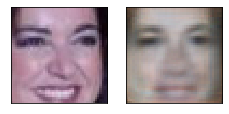

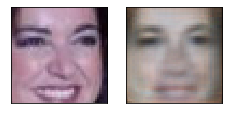

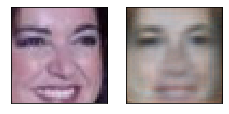

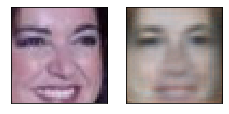

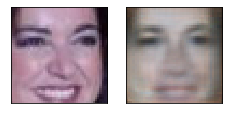

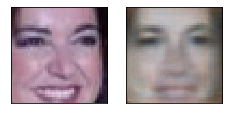

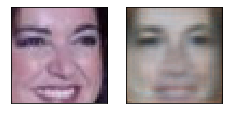

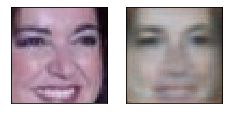

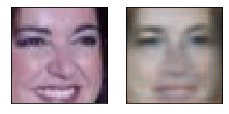

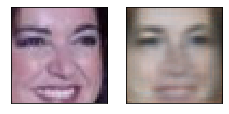

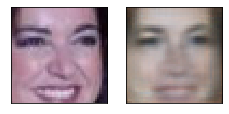

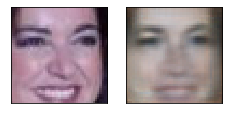

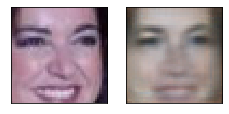

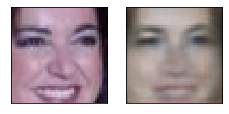

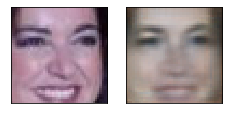

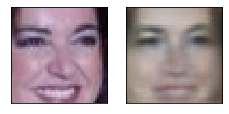

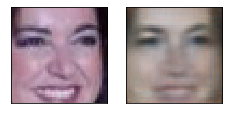

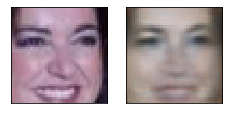

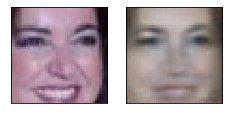

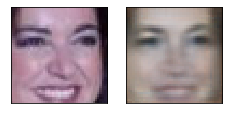

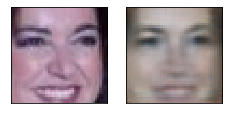

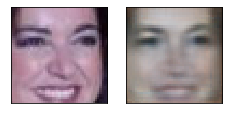

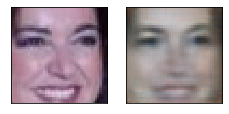

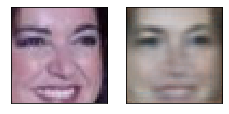

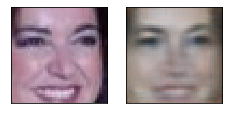

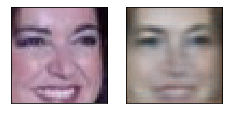

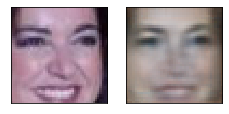

In [101]:
history = train(X_train, X_val, model, epochs=50, batch_size=64)


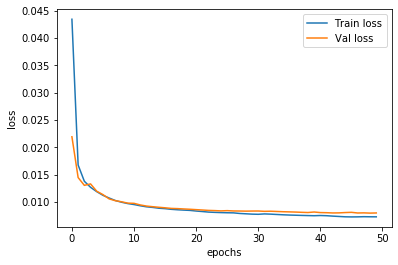

In [103]:
train_loss, val_loss = zip(*history)
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

### Inference

(25, 1024)


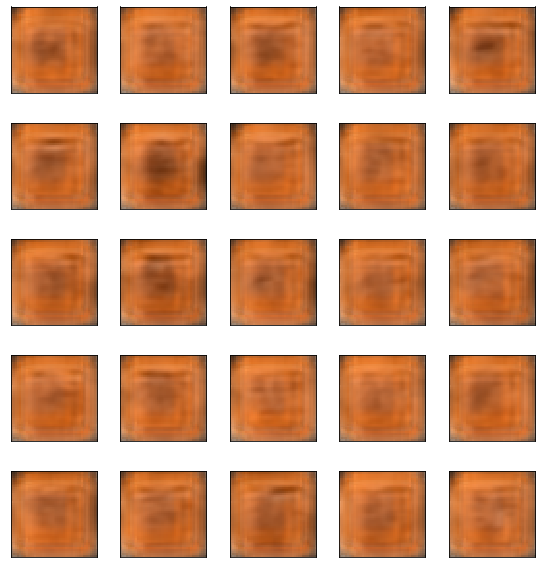

In [134]:
z = np.random.randn(25, 1024)
print(z.shape)

with torch.no_grad():
    inputs = torch.FloatTensor(z)    
    inputs = inputs.to(device)
    model.eval()
    output = model.decoder(inputs)
    output = output.permute(0, 2, 3, 1)
    plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

Что логично так как в автоэнкодерах латентное пространство недостаточно регулярноe.

In [133]:
attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [0]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = data[no_smile_ids]

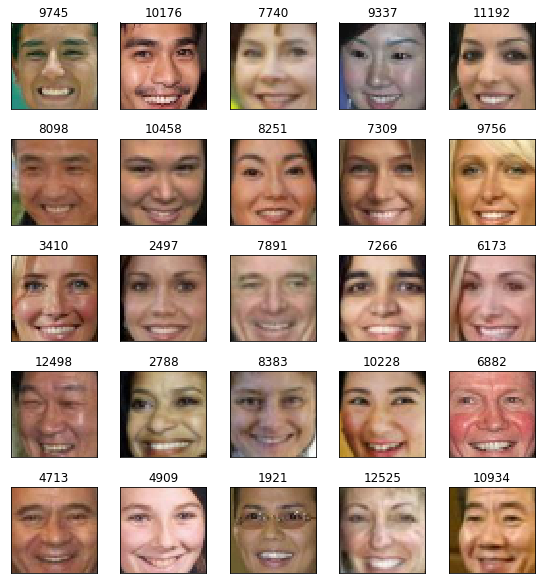

In [136]:
plot_gallery(smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=smile_ids)

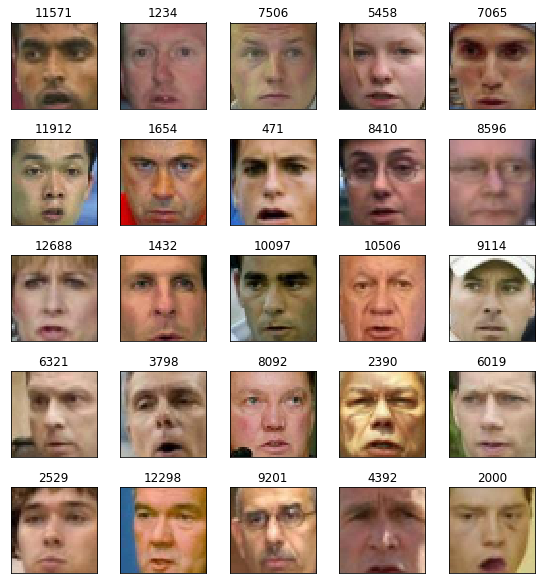

In [137]:
plot_gallery(no_smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=no_smile_ids)

In [0]:
def to_latent(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic)
        inputs = inputs.permute(0,3,1,2)
        inputs = inputs.to(device)
        model.eval()
        output = model.encoder(inputs)        
        return output

def from_latent(vec):
    with torch.no_grad():
        inputs = vec.to(device)
        model.eval()
        output = model.decoder(inputs)
        return output

In [0]:
smile_latent = to_latent(smile_data).mean(axis=0)
no_smile_latent = to_latent(no_smile_data).mean(axis=0)

smile_vec = smile_latent-no_smile_latent

def make_me_smile(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += smile_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.permute(0,2,3,1)
        pic_output = pic_output.cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


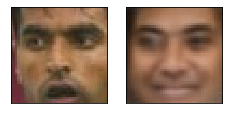

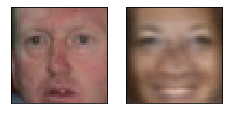

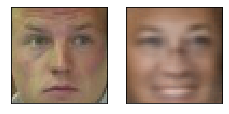

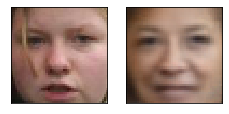

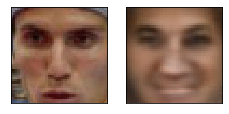

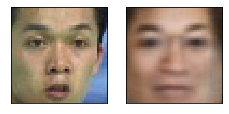

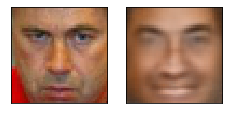

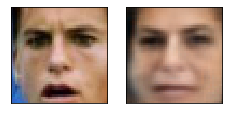

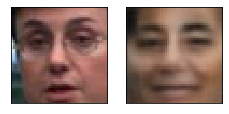

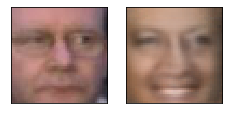

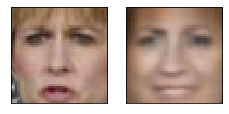

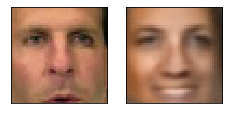

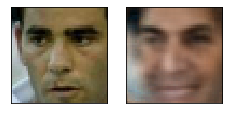

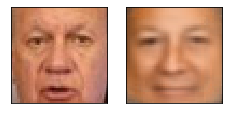

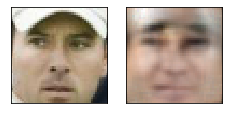

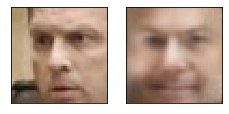

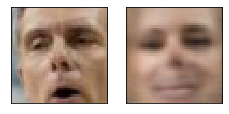

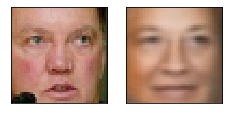

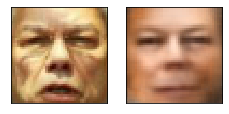

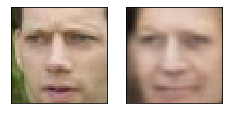

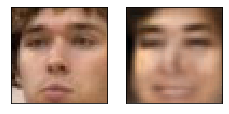

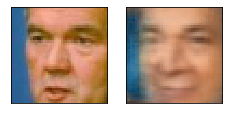

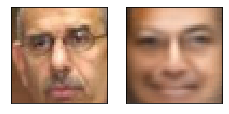

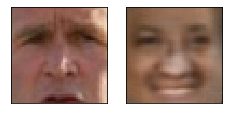

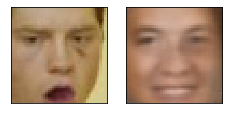

In [165]:
make_me_smile(no_smile_ids)

# VAE

### Model

In [0]:
class EncoderVAE(nn.Module):
  def __init__(self, latent_size):
    super(EncoderVAE, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(45*45*3, 1024), 
      nn.ReLU(True),
      nn.Linear(1024, 4096),
      nn.ReLU(True)   
    )
    self.mu_repr = nn.Linear(4096, latent_size)
    self.sigma_repr = nn.Linear(4096, latent_size)

  def forward(self, x):
    x = self.model(x)
    mu = self.mu_repr(x)
    sigma = self.sigma_repr(x)
    return mu, sigma

In [0]:
class DecoderVAE(nn.Module):
  def __init__(self, latent_size):
    super(DecoderVAE, self).__init__()
    self.fc = nn.Linear(latent_size, 289)
    self.model = nn.Sequential(
        nn.ConvTranspose2d(in_channels=1, out_channels=8, kernel_size=5),
        nn.LeakyReLU(0.05, True),
        nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=5),
        nn.LeakyReLU(0.05, True),
        nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=5),
        nn.LeakyReLU(0.05, True),
        nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=5),
        nn.LeakyReLU(0.05, True),
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5),
        nn.LeakyReLU(0.05, True),
        nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5),
        nn.LeakyReLU(0.05, True),
        nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=5),
        nn.LeakyReLU(0.05, True)
    )
  
  def forward(self, x):
    x = self.fc(x)
    x = x.view(x.size(0), 1, 17, 17)
    return self.model(x)

In [0]:
class VAE(nn.Module):
  def __init__(self, latent_size):
    super(VAE, self).__init__()
    self.decoder = DecoderVAE(latent_size)
    self.encoder = EncoderVAE(latent_size)

  def reparametrize(self, mu, logvar):
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mu)

  def forward(self, x):
    mu, logvar = self.encoder(x)
    z = self.reparametrize(mu, logvar)
    z = self.decoder(z)
    return x, mu, logvar

### Train

In [0]:
def loss_vae_fn(x, recon_x, mu, logvar):    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [0]:
vae = VAE(1024).to(device)

In [0]:
def fit_epoch_vae(model, train_x, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(device)        
        optimizer.zero_grad()
        
        decoded,mu,logvar, = model(inputs)
        outputs = decoded.view(-1, 45*45*3)
        outputs = outputs.to(device)
        
        loss = loss_vae_fn(inputs,outputs,mu,logvar)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch_vae(model, x_val, batch_size):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val,batch_size=batch_size):
        inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(device)
        
        with torch.set_grad_enabled(False):
            decoded,mu,logvar = model(inputs)
            outputs = decoded.view(-1, 45*45*3)        
            loss = loss_vae_fn(inputs,outputs,mu,logvar)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]         
        pic_input = pic.view(-1, 45*45*3)            
        pic_input = pic_input.to(device)        
        decoded,mu,logvar = model(inputs)        
        pic_output = decoded[0].view(-1, 45*45*3).squeeze()
        pic_output = pic_output.to("cpu") 
        pic_input = pic_input.to("cpu")
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train_vae(train_x, val_x, model, epochs=10, batch_size=32, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch_vae(model,train_x,optimizer,batch_size)
            val_loss = eval_epoch_vae(model,val_x,batch_size)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

epoch:   2%|▏         | 1/50 [00:02<01:53,  2.31s/it]

loss:  460794.4729347826

Epoch 001 train_loss: 460794.4729 val_loss: 457683.4083


epoch:   4%|▍         | 2/50 [00:04<01:49,  2.28s/it]

loss:  459135.8616304348

Epoch 002 train_loss: 459135.8616 val_loss: 457683.1922


epoch:   6%|▌         | 3/50 [00:06<01:46,  2.26s/it]

loss:  459135.82467391307

Epoch 003 train_loss: 459135.8247 val_loss: 457683.1922


epoch:   8%|▊         | 4/50 [00:08<01:43,  2.25s/it]

loss:  459135.82467391307

Epoch 004 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  10%|█         | 5/50 [00:11<01:40,  2.24s/it]

loss:  459135.82467391307

Epoch 005 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  12%|█▏        | 6/50 [00:13<01:38,  2.24s/it]

loss:  459135.82467391307

Epoch 006 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  14%|█▍        | 7/50 [00:15<01:36,  2.23s/it]

loss:  459135.82467391307

Epoch 007 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  16%|█▌        | 8/50 [00:17<01:33,  2.23s/it]

loss:  459135.82467391307

Epoch 008 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  18%|█▊        | 9/50 [00:20<01:31,  2.23s/it]

loss:  459135.82467391307

Epoch 009 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  20%|██        | 10/50 [00:22<01:29,  2.23s/it]

loss:  459135.82467391307

Epoch 010 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  22%|██▏       | 11/50 [00:24<01:27,  2.24s/it]

loss:  459135.82467391307

Epoch 011 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  24%|██▍       | 12/50 [00:26<01:25,  2.24s/it]

loss:  459135.82467391307

Epoch 012 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  26%|██▌       | 13/50 [00:29<01:23,  2.24s/it]

loss:  459135.82467391307

Epoch 013 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  28%|██▊       | 14/50 [00:31<01:20,  2.25s/it]

loss:  459135.82467391307

Epoch 014 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  30%|███       | 15/50 [00:33<01:18,  2.25s/it]

loss:  459135.82467391307

Epoch 015 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  32%|███▏      | 16/50 [00:35<01:16,  2.25s/it]

loss:  459135.82467391307

Epoch 016 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  34%|███▍      | 17/50 [00:38<01:14,  2.25s/it]

loss:  459135.82467391307

Epoch 017 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  36%|███▌      | 18/50 [00:40<01:12,  2.26s/it]

loss:  459135.82467391307

Epoch 018 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  38%|███▊      | 19/50 [00:42<01:10,  2.26s/it]

loss:  459135.82467391307

Epoch 019 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  40%|████      | 20/50 [00:44<01:07,  2.26s/it]

loss:  459135.82467391307

Epoch 020 train_loss: 459135.8247 val_loss: 457683.1922


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
epoch:  42%|████▏     | 21/50 [00:47<01:06,  2.29s/it]

loss:  459135.82467391307

Epoch 021 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  44%|████▍     | 22/50 [00:49<01:04,  2.29s/it]

loss:  459135.82467391307

Epoch 022 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  46%|████▌     | 23/50 [00:51<01:01,  2.29s/it]

loss:  459135.82467391307

Epoch 023 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  48%|████▊     | 24/50 [00:54<00:59,  2.29s/it]

loss:  459135.82467391307

Epoch 024 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  50%|█████     | 25/50 [00:56<00:57,  2.29s/it]

loss:  459135.82467391307

Epoch 025 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  52%|█████▏    | 26/50 [00:58<00:54,  2.28s/it]

loss:  459135.82467391307

Epoch 026 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  54%|█████▍    | 27/50 [01:00<00:52,  2.29s/it]

loss:  459135.82467391307

Epoch 027 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  56%|█████▌    | 28/50 [01:03<00:50,  2.29s/it]

loss:  459135.82467391307

Epoch 028 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  58%|█████▊    | 29/50 [01:05<00:48,  2.29s/it]

loss:  459135.82467391307

Epoch 029 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  60%|██████    | 30/50 [01:07<00:45,  2.29s/it]

loss:  459135.82467391307

Epoch 030 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  62%|██████▏   | 31/50 [01:10<00:43,  2.30s/it]

loss:  459135.82467391307

Epoch 031 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  64%|██████▍   | 32/50 [01:12<00:41,  2.30s/it]

loss:  459135.82467391307

Epoch 032 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  66%|██████▌   | 33/50 [01:14<00:39,  2.30s/it]

loss:  459135.82467391307

Epoch 033 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  68%|██████▊   | 34/50 [01:17<00:36,  2.30s/it]

loss:  459135.82467391307

Epoch 034 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  70%|███████   | 35/50 [01:19<00:34,  2.31s/it]

loss:  459135.82467391307

Epoch 035 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  72%|███████▏  | 36/50 [01:21<00:32,  2.31s/it]

loss:  459135.82467391307

Epoch 036 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  74%|███████▍  | 37/50 [01:24<00:30,  2.31s/it]

loss:  459135.82467391307

Epoch 037 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  76%|███████▌  | 38/50 [01:26<00:27,  2.32s/it]

loss:  459135.82467391307

Epoch 038 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  78%|███████▊  | 39/50 [01:28<00:25,  2.32s/it]

loss:  459135.82467391307

Epoch 039 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  80%|████████  | 40/50 [01:31<00:23,  2.33s/it]

loss:  459135.82467391307

Epoch 040 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  82%|████████▏ | 41/50 [01:33<00:20,  2.33s/it]

loss:  459135.82467391307

Epoch 041 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  84%|████████▍ | 42/50 [01:35<00:18,  2.33s/it]

loss:  459135.82467391307

Epoch 042 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  86%|████████▌ | 43/50 [01:38<00:16,  2.34s/it]

loss:  459135.82467391307

Epoch 043 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  88%|████████▊ | 44/50 [01:40<00:14,  2.34s/it]

loss:  459135.82467391307

Epoch 044 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  90%|█████████ | 45/50 [01:42<00:11,  2.34s/it]

loss:  459135.82467391307

Epoch 045 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  92%|█████████▏| 46/50 [01:45<00:09,  2.34s/it]

loss:  459135.82467391307

Epoch 046 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  94%|█████████▍| 47/50 [01:47<00:07,  2.38s/it]

loss:  459135.82467391307

Epoch 047 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  96%|█████████▌| 48/50 [01:49<00:04,  2.37s/it]

loss:  459135.82467391307

Epoch 048 train_loss: 459135.8247 val_loss: 457683.1922


epoch:  98%|█████████▊| 49/50 [01:52<00:02,  2.37s/it]

loss:  459135.82467391307

Epoch 049 train_loss: 459135.8247 val_loss: 457683.1922


epoch: 100%|██████████| 50/50 [01:54<00:00,  2.36s/it]

loss:  459135.82467391307

Epoch 050 train_loss: 459135.8247 val_loss: 457683.1922


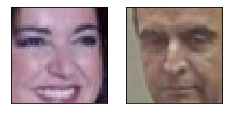

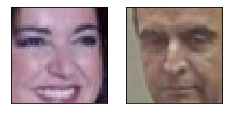

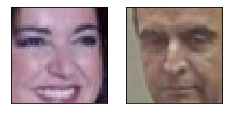

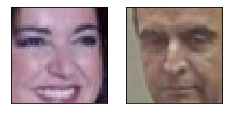

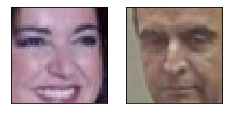

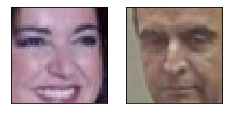

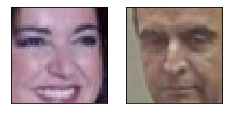

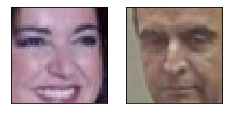

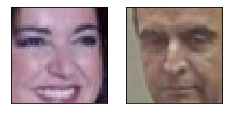

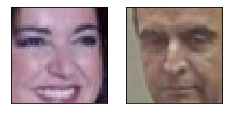

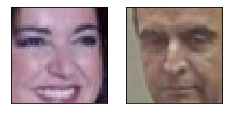

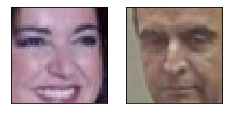

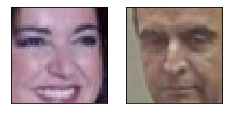

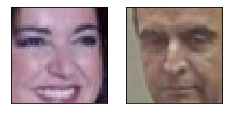

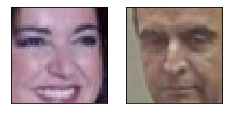

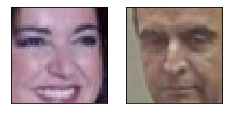

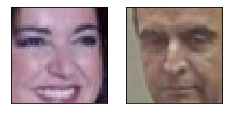

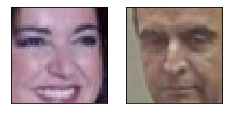

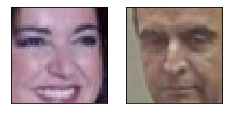

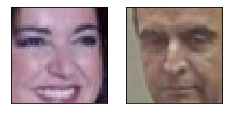

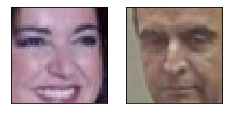

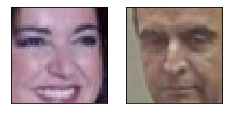

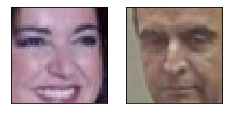

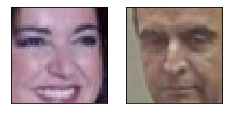

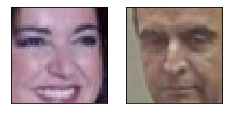

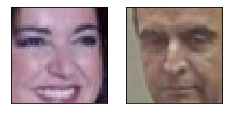

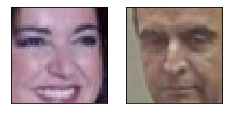

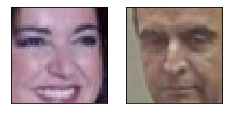

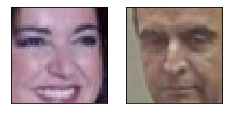

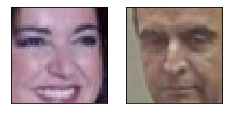

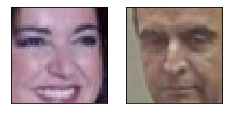

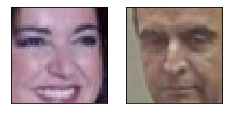

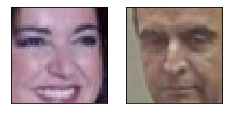

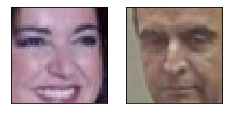

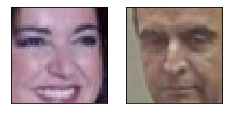

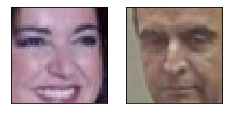

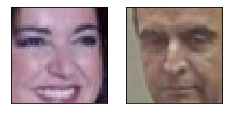

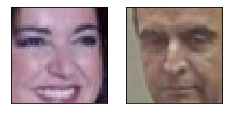

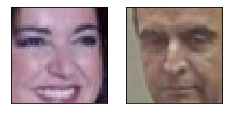

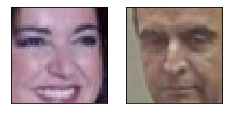

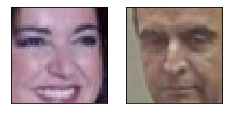

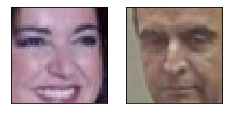

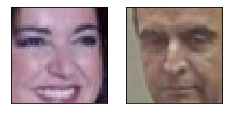

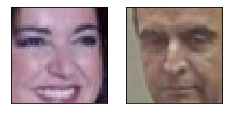

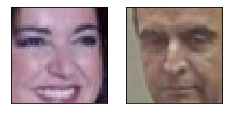

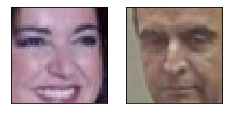

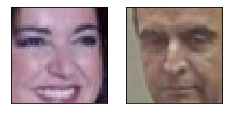

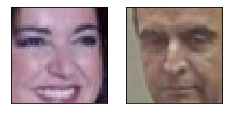

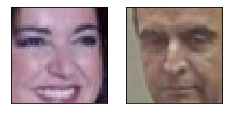

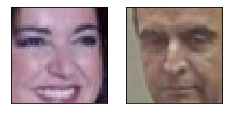

In [206]:
history_vae = train_vae(X_train, X_val, vae, epochs=50, batch_size=128, lr=0.001)